In [1]:
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

Data generators

In [ ]:
DATA_DIR = '../data/processed'

BATCH_SIZE = 35
IMG_SIZE = 224

datagen = ImageDataGenerator(
    preprocessing_function=applications.mobilenet_v2.preprocess_input
)

train_generator = datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


Create model MobileNetV2

In [ ]:
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)

def create_model():
    base_model = applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

model = create_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, 'mobilenetv2_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

Training

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)
model.save(os.path.join(MODEL_DIR, 'mobilenetv2_final.h5'))
class_indices = train_generator.class_indices
np.save(os.path.join(MODEL_DIR, 'class_indices.npy'), class_indices)
history_path = os.path.join(MODEL_DIR, 'history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 2.6989 - accuracy: 0.2071

c:\Users\kiril\OneDrive - The University of Melbourne\ML\Seek pass case study\Proj\model\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 60s 3s/step - loss: 2.6989 - accuracy: 0.2071 - val_loss: 2.2799 - val_accuracy: 0.1867
Epoch 2/20
20/20 [==============================] - 54s 3s/step - loss: 1.3335 - accuracy: 0.5414 - val_loss: 1.4988 - val_accuracy: 0.4600
Epoch 3/20
20/20 [==============================] - 53s 3s/step - loss: 0.8505 - accuracy: 0.7229 - val_loss: 1.2507 - val_accuracy: 0.5667
Epoch 4/20
20/20 [==============================] - 53s 3s/step - loss: 0.6088 - accuracy: 0.8171 - val_loss: 0.9779 - val_accuracy: 0.7000
Epoch 5/20
20/20 [==============================] - 53s 3s/step - loss: 0.4530 - accuracy: 0.8600 - val_loss: 0.9189 - val_accuracy: 0.7067
Epoch 6/20
20/20 [==============================] - 53s 3s/step - loss: 0.3556 - accuracy: 0.9200 - val_loss: 0.8833 - val_accuracy: 0.6800
Epoch 7/20
20/20 [==============================] - 53s 3s/step - loss: 0.2800 - accuracy: 0.9400 - val_loss: 0.8316 - val_accuracy: 0.7133
Epoch 8/20
20/20 [=============

Evaluation

In [ ]:
model_path = os.path.join(MODEL_DIR, 'mobilenetv2_best.h5')

model = keras.models.load_model(model_path)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

5/5 [==============================] - 12s 2s/step - loss: 0.5771 - accuracy: 0.7867
Test accuracy: 0.7867
Test loss: 0.5771


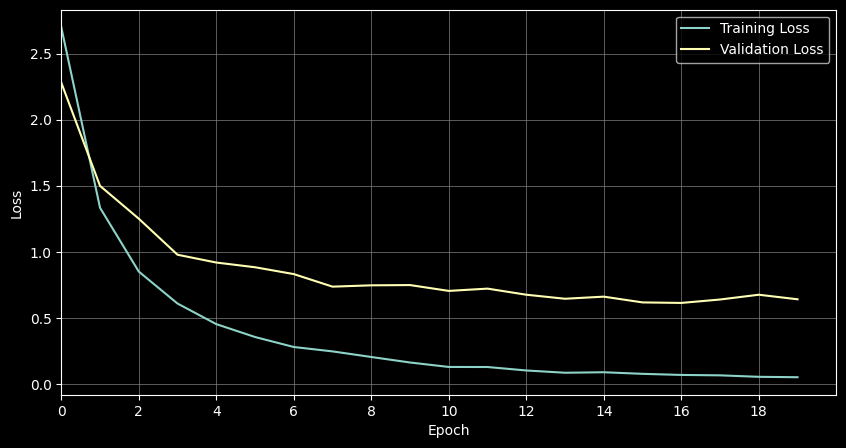

In [ ]:
import matplotlib.pyplot as plt

history_path = os.path.join(MODEL_DIR, 'history.pkl')
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlim(0, len(loaded_history['loss']))
plt.xticks(np.arange(0, len(loaded_history['loss']), 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

In [ ]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Added: define class_names from test_generator's class indices
class_names = list(test_generator.class_indices.keys())

# Calculate per-class accuracy
per_class_accuracy = {}
for class_id in range(len(class_names)):
    class_indices = np.where(y_true == class_id)[0]
    if len(class_indices) > 0:
        class_accuracy = np.mean(y_pred_classes[class_indices] == class_id)
        per_class_accuracy[class_names[class_id]] = class_accuracy

# Print per-class accuracy
print('\nPer-class accuracy:')
for class_name, accuracy in per_class_accuracy.items():
    print(f'{class_name}: {accuracy:.4f}')

5/5 [==============================] - 11s 2s/step
[[10  0  3  0  0  0  0  0  1  1]
 [ 0 14  0  1  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  1]
 [ 0  0  0 13  1  0  0  0  1  0]
 [ 5  1  3  2  3  0  0  0  0  1]
 [ 0  0  0  0  0 12  2  0  1  0]
 [ 0  1  0  0  0  0 13  0  1  0]
 [ 0  0  0  0  0  1  0 12  2  0]
 [ 0  0  0  0  0  1  0  0 14  0]
 [ 1  0  1  0  0  0  0  0  0 13]]

Per-class accuracy:
alb_id: 0.6667
aze_passport: 0.9333
esp_id: 0.9333
est_id: 0.8667
fin_id: 0.2000
grc_passport: 0.8000
lva_passport: 0.8667
rus_internalpassport: 0.8000
srb_passport: 0.9333
svk_id: 0.8667


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

                      precision    recall  f1-score   support

              alb_id       0.62      0.67      0.65        15
        aze_passport       0.88      0.93      0.90        15
              esp_id       0.67      0.93      0.78        15
              est_id       0.81      0.87      0.84        15
              fin_id       0.75      0.20      0.32        15
        grc_passport       0.86      0.80      0.83        15
        lva_passport       0.87      0.87      0.87        15
rus_internalpassport       1.00      0.80      0.89        15
        srb_passport       0.70      0.93      0.80        15
              svk_id       0.81      0.87      0.84        15

            accuracy                           0.79       150
           macro avg       0.80      0.79      0.77       150
        weighted avg       0.80      0.79      0.77       150

